In [81]:
!pip install torchinfo

In [82]:
#Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import models
from torchinfo import summary
from tqdm import tqdm

In [83]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [84]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


In [85]:
# @title Set device (GPU or CPU)

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [86]:
set_seed(seed=2021)
device = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


Load and Prepare Dataset

In [87]:
emotions = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}
emotions_inv = {v:k for k,v in emotions.items()}

In [88]:
class FER2013(Dataset):
    def __init__(self, csv_file:str, split:str='Training', transforms:transforms.Compose=None):
      """
      Arguments:
          csv_file (string): Path to the FER2013 icml_face_data.csv file with annotations.
          split = 'Training' for train , 'PublicTest' for validation, 'PrivateTest' for test
          transform (callable, optional): Optional transform to be applied on a sample.
      """
      self._main_df = pd.read_csv(csv_file)
      self.split = split
      self.transforms = transforms
      self._samples = self._load()

    def __len__(self):
        return len(self._samples)

    def __getitem__(self, idx):
        img, label = self._samples[idx]
        img = torch.as_tensor(img).float()
        if self.transforms:
            img = self.transforms(img)
        return img, label

    def _load(self):
      df = self._main_df
      df.columns = df.columns.str.replace(' ', '')
      df = df[df['Usage'] == self.split].copy()
      samples = []
      for index, row in df.iterrows():
          label = row['emotion']
          onehot_label = np.zeros(len(emotions))
          onehot_label[label] = 1
          img_arr = row['pixels'].split(' ')
          img_arr = np.array(img_arr).astype(int)
          img_arr = img_arr.reshape(48,48)
          samples.append((img_arr, onehot_label))
      samples = np.array(samples, dtype=object)
      return samples

In [89]:
# Define the batch size
batch_size = 128
torchvision_transforms = True  # True/False if you want use torchvision augmentations
dataset_csv_file = "/content/drive/MyDrive/Colab Notebooks/dataset/fer2013/icml_face_data.csv"


# Define the transformations to apply
transforms_train = transforms.Compose([transforms.ToPILImage()])
if torchvision_transforms:
    transforms_train.transforms.extend([
                transforms.RandomRotation(10),
                transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(size=48, padding=4)])

transforms_train.transforms.extend([
                transforms.Grayscale(num_output_channels=3),
                transforms.ToTensor()])

transforms_validation = transforms.Compose([transforms.ToPILImage(),
                                            transforms.Grayscale(num_output_channels=3),
                                            transforms.ToTensor()])

transforms_test = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Grayscale(num_output_channels=3),
                                      transforms.ToTensor()])
# Create the dataset
train_dataset = FER2013(csv_file=dataset_csv_file, split='Training', transforms=transforms_train)
validation_dataset = FER2013(csv_file=dataset_csv_file, split='PublicTest', transforms=transforms_validation)
test_dataset = FER2013(csv_file=dataset_csv_file, split='PrivateTest', transforms=transforms_test)

# Create the data loader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [90]:
def show_dataloader_batch(dataloader):
  batch = next(iter(dataloader))
  # Extract the images and labels from the batch
  images, labels = batch
  images, labels = images[:20], labels[:20]
  # fig = plt.figure(figsize=(10, 10))
  for i in range(len(images)):
      ax = plt.subplot(4,len(images)//4, i+ 1)
      image = images[i]
      if len(image.shape) == 3:
        image = image.permute(1,2,0)
      ax.imshow(image, cmap="gray")
      ax.set_title(f"{emotions[np.nonzero(labels[i]).item()]}")
      ax.axis('off')
  plt.tight_layout()
  plt.show()

def show_dataset_batch(dataset, batch_size=20):
  for i in range(batch_size):
      image, label = dataset._samples[i]
      ax = plt.subplot(4, batch_size//4, i+ 1)
      if len(image.shape) == 3:
        image = image.permute(1,2,0)
      ax.imshow(image, cmap="gray")
      ax.set_title(f"{emotions[np.nonzero(label)[0][0]]}")
      ax.axis('off')
  plt.tight_layout()
  plt.show()

Train Dataset Samples


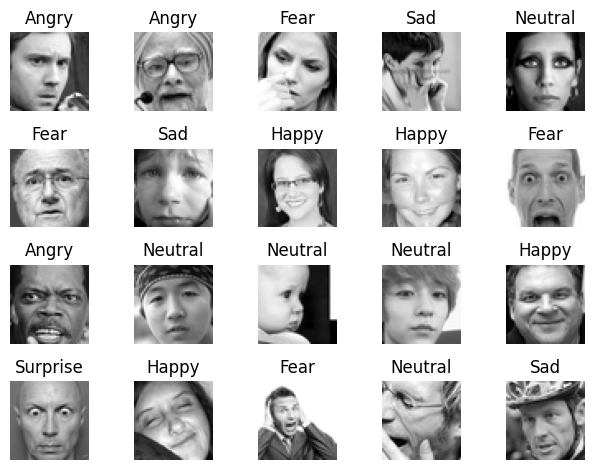

Transformed Train Dataset Samples


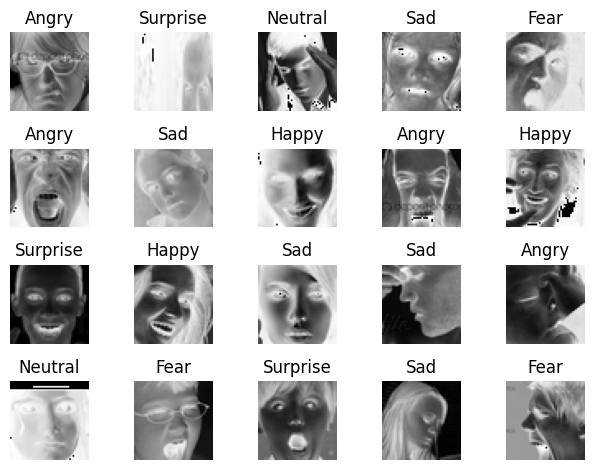

In [91]:
print("Train Dataset Samples")
show_dataset_batch(train_dataset)
print("Transformed Train Dataset Samples")
show_dataloader_batch(test_dataloader)

In [92]:
#Preprocessing
# Face Alignment

Architecture 01: ResNet

In [93]:
# Define Resnet model and download pre-trained weights
resnet_model = models.resnet18(weights="IMAGENET1K_V1")

# Freeze Layers
for param in resnet_model.parameters():
  param.requires_grad = True

# Display model summary
# summary(resnet_model, input_size=(1, 3, 48, 48))

In [94]:
# Change the last Layer:
resnet_model.fc = torch.nn.Linear(in_features=512, out_features=7)
# Display model summary
# summary(resnet_model, input_size=(1, 3, 48, 48))

Set up training

In [95]:
base_learning_rate = 1e-4
best_acc = 0

In [96]:
def plot_history(history):
  # Plotting
  plt.figure(figsize=(10,3))
  ax = plt.subplot(1,2,1)
  ax.plot(history.train_loss)
  ax.plot(history.validation_loss)
  ax.plot(history.test_loss)
  ax.set_title("Loss")
  ax.legend(["train_loss", "val_loss", "test_loss"])
  ax = plt.subplot(1,2,2)
  ax.plot(history.train_acc)
  ax.plot(history.validation_acc)
  ax.plot(history.test_acc)
  ax.set_ylim(0,100)
  ax.set_title("Accuracy")
  ax.legend(["train_acc", "val_acc", "test_acc"])
  plt.tight_layout()
  plt.show()

In [97]:

# checkpoint & adjust_learning_rate
def checkpoint(model, acc, epoch, out_model_name):
  # Save checkpoint.
  print('Saving..')
  state = {
      'state_dict': model.state_dict(),
      'acc': acc,
      'epoch': epoch,
      'rng_state': torch.get_rng_state()
  }
  if not os.path.isdir('checkpoint'):
      os.mkdir('checkpoint')
  torch.save(state, f'./checkpoint/{out_model_name}.t7')

def adjust_learning_rate(optimizer, epoch):
  """decrease the learning rate at 100 and 150 epoch"""
  lr = base_learning_rate
  if epoch <= 9 and lr > 0.1:
    # warm-up training for large minibatch
    lr = 0.1 + (base_learning_rate - 0.1) * epoch / 10.
  if epoch >= 100:
    lr /= 10
  if epoch >= 150:
    lr /= 10
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

In [98]:
class History:
  def __init__(self):
    self.train_acc = []
    self.validation_acc = []
    self.test_acc = []
    self.train_loss = []
    self.validation_loss = []
    self.test_loss = []

  def append_results(self, loss, acc, split):
    if split == "train":
      self.train_loss.append(loss)
      self.train_acc.append(acc)
    if split == "validation":
      self.validation_loss.append(loss)
      self.validation_acc.append(acc)
    if split == "test":
      self.test_loss.append(loss)
      self.test_acc.append(acc)

 1- Set loss function and optimizer

In [99]:
# Optimizer and criterion
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=base_learning_rate)

 Training & Test functions

In [130]:
def train(net, epoch, use_cuda=True, pbar=None):
  net.train()
  train_loss = 0
  correct = 0
  total = 0
  # pbar = tqdm(enumerate(train_dataloader))
  for batch_idx, (inputs, targets) in enumerate(train_dataloader):
    if use_cuda:
      inputs, targets = inputs.cuda(), targets.cuda()

    optimizer.zero_grad()
    inputs, targets = Variable(inputs), Variable(targets)
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    real = np.apply_along_axis(lambda x: np.nonzero(x)[0][0], 1, targets.data.cpu())
    correct += predicted.cpu().eq(torch.from_numpy(real)).sum()
    result = f"Epoch:{epoch} Training-Batch: {batch_idx}/{len(train_dataloader)}| Loss: {(train_loss/(batch_idx+1)):0.3f} | Acc: {(100.*correct/total):0.3f}"
    pbar.set_description(result)
  return (train_loss/batch_idx, 100.*correct/total)

def test(net, epoch, out_model_name, use_cuda=True, pbar=None):
  global best_acc
  net.eval()
  test_loss, correct, total = 0, 0, 0
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(validation_dataloader):
      if use_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()

      outputs = net(inputs)
      loss = criterion(outputs, targets)

      test_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      real = np.apply_along_axis(lambda x: np.nonzero(x)[0][0], 1, targets.data.cpu())
      total += targets.size(0)
      correct += predicted.cpu().eq(torch.from_numpy(real)).cpu().sum()
      result = f"Epoch:{epoch} Testing-Batch: {batch_idx}/{len(validation_dataloader)}| Loss: {(test_loss/(batch_idx+1)):0.3f} | Acc: {(100.*correct/total):0.3f}"
      pbar.set_description(result)

  # # Save checkpoint.
  # acc = 100.*correct/total
  # if acc > best_acc:
  #   best_acc = acc
  #   checkpoint(net, acc, epoch, out_model_name)
  return (test_loss/batch_idx, 100.*correct/total)

Train the model

In [131]:
start_epoch = 0
max_epochs = 40
use_cuda = True
out_model_name = "resnet18"
history = History()
pbar = tqdm(range(start_epoch, max_epochs))
resnet_model.to(device)
for epoch in pbar:
  # adjust_learning_rate(optimizer, epoch)
  train_loss, train_acc = train(resnet_model, epoch, use_cuda=use_cuda, pbar=pbar)
  history.append_results(train_loss, train_acc, "train")
  test_loss, test_acc = test(resnet_model, epoch, out_model_name, use_cuda=use_cuda, pbar=pbar)
  history.append_results(test_loss, test_acc, "validation")
  print(f'  Epoch:{epoch + 1} | Train acc: {train_acc} | Validation acc: {test_acc}')

Epoch:1 Training-Batch: 0/225| Loss: 1.258 | Acc: 46.875:   2%|▎         | 1/40 [00:33<21:37, 33.27s/it]

  Epoch:1 | Train acc: 49.43049240112305 | Validation acc: 52.995262145996094


Epoch:2 Training-Batch: 0/225| Loss: 1.195 | Acc: 48.438:   5%|▌         | 2/40 [01:05<20:45, 32.77s/it]

  Epoch:2 | Train acc: 54.09453582763672 | Validation acc: 55.22429656982422


Epoch:3 Training-Batch: 0/225| Loss: 1.136 | Acc: 56.250:   8%|▊         | 3/40 [01:40<20:39, 33.49s/it]

  Epoch:3 | Train acc: 57.2120246887207 | Validation acc: 56.533851623535156


Epoch:4 Training-Batch: 0/225| Loss: 1.033 | Acc: 59.375:  10%|█         | 4/40 [02:13<19:58, 33.28s/it]

  Epoch:4 | Train acc: 59.44825744628906 | Validation acc: 58.95792770385742


Epoch:5 Training-Batch: 0/225| Loss: 0.963 | Acc: 61.719:  12%|█▎        | 5/40 [02:45<19:08, 32.80s/it]

  Epoch:5 | Train acc: 61.65662384033203 | Validation acc: 59.40373229980469


Epoch:6 Training-Batch: 0/225| Loss: 0.990 | Acc: 59.375:  15%|█▌        | 6/40 [03:19<18:54, 33.37s/it]

  Epoch:6 | Train acc: 63.75701141357422 | Validation acc: 60.04458236694336


Epoch:7 Training-Batch: 0/225| Loss: 0.869 | Acc: 63.281:  18%|█▊        | 7/40 [03:51<18:04, 32.87s/it]

  Epoch:7 | Train acc: 65.98279571533203 | Validation acc: 60.01671600341797


Epoch:8 Training-Batch: 0/225| Loss: 0.858 | Acc: 69.531:  20%|██        | 8/40 [04:23<17:21, 32.55s/it]

  Epoch:8 | Train acc: 67.47361755371094 | Validation acc: 59.71022415161133


Epoch:9 Training-Batch: 0/225| Loss: 0.788 | Acc: 67.969:  22%|██▎       | 9/40 [04:56<16:54, 32.74s/it]

  Epoch:9 | Train acc: 69.66107940673828 | Validation acc: 60.685428619384766


Epoch:10 Training-Batch: 0/225| Loss: 0.747 | Acc: 72.656:  25%|██▌       | 10/40 [05:28<16:18, 32.62s/it]

  Epoch:10 | Train acc: 72.08192443847656 | Validation acc: 60.26748275756836


Epoch:11 Training-Batch: 0/225| Loss: 0.714 | Acc: 67.188:  28%|██▊       | 11/40 [06:01<15:50, 32.78s/it]

  Epoch:11 | Train acc: 74.42265319824219 | Validation acc: 60.26748275756836


Epoch:12 Training-Batch: 0/225| Loss: 0.704 | Acc: 69.531:  30%|███       | 12/40 [06:34<15:15, 32.70s/it]

  Epoch:12 | Train acc: 76.04583740234375 | Validation acc: 61.13123321533203


Epoch:13 Training-Batch: 0/225| Loss: 0.614 | Acc: 74.219:  32%|███▎      | 13/40 [07:06<14:35, 32.41s/it]

  Epoch:13 | Train acc: 78.2785873413086 | Validation acc: 60.65756607055664


Epoch:14 Training-Batch: 0/225| Loss: 0.490 | Acc: 81.250:  35%|███▌      | 14/40 [07:39<14:06, 32.54s/it]

  Epoch:14 | Train acc: 80.57403564453125 | Validation acc: 60.90833282470703


Epoch:15 Training-Batch: 0/225| Loss: 0.427 | Acc: 86.719:  38%|███▊      | 15/40 [08:13<13:44, 32.97s/it]

  Epoch:15 | Train acc: 82.09272003173828 | Validation acc: 61.32627487182617


Epoch:16 Training-Batch: 0/225| Loss: 0.433 | Acc: 84.375:  40%|████      | 16/40 [08:45<13:05, 32.73s/it]

  Epoch:16 | Train acc: 83.66714477539062 | Validation acc: 60.490386962890625


Epoch:17 Training-Batch: 0/225| Loss: 0.491 | Acc: 82.031:  42%|████▎     | 17/40 [09:18<12:35, 32.84s/it]

  Epoch:17 | Train acc: 85.42965698242188 | Validation acc: 61.159095764160156


Epoch:18 Training-Batch: 0/225| Loss: 0.389 | Acc: 84.375:  45%|████▌     | 18/40 [09:51<12:04, 32.94s/it]

  Epoch:18 | Train acc: 86.97969055175781 | Validation acc: 61.66062927246094


Epoch:19 Training-Batch: 0/225| Loss: 0.280 | Acc: 89.062:  48%|████▊     | 19/40 [10:23<11:25, 32.65s/it]

  Epoch:19 | Train acc: 87.7181396484375 | Validation acc: 61.159095764160156


Epoch:20 Training-Batch: 0/225| Loss: 0.248 | Acc: 89.844:  50%|█████     | 20/40 [10:56<10:54, 32.70s/it]

  Epoch:20 | Train acc: 89.1009750366211 | Validation acc: 60.546112060546875


Epoch:21 Training-Batch: 0/225| Loss: 0.416 | Acc: 82.031:  52%|█████▎    | 21/40 [11:28<10:19, 32.59s/it]

  Epoch:21 | Train acc: 90.10066223144531 | Validation acc: 60.573974609375


Epoch:22 Training-Batch: 0/225| Loss: 0.314 | Acc: 86.719:  55%|█████▌    | 22/40 [12:01<09:48, 32.69s/it]

  Epoch:22 | Train acc: 90.20864868164062 | Validation acc: 60.685428619384766


Epoch:23 Training-Batch: 0/225| Loss: 0.193 | Acc: 92.969:  57%|█████▊    | 23/40 [12:33<09:14, 32.59s/it]

  Epoch:23 | Train acc: 91.51485443115234 | Validation acc: 62.83087158203125


Epoch:24 Training-Batch: 0/225| Loss: 0.257 | Acc: 90.625:  60%|██████    | 24/40 [13:05<08:39, 32.45s/it]

  Epoch:24 | Train acc: 92.39263153076172 | Validation acc: 61.77207946777344


Epoch:25 Training-Batch: 0/225| Loss: 0.283 | Acc: 91.406:  62%|██████▎   | 25/40 [13:39<08:11, 32.75s/it]

  Epoch:25 | Train acc: 92.45184326171875 | Validation acc: 62.16216278076172


Epoch:26 Training-Batch: 0/225| Loss: 0.201 | Acc: 92.188:  65%|██████▌   | 26/40 [14:12<07:41, 32.94s/it]

  Epoch:26 | Train acc: 92.9882583618164 | Validation acc: 61.77207946777344


Epoch:27 Training-Batch: 0/225| Loss: 0.205 | Acc: 92.188:  68%|██████▊   | 27/40 [14:45<07:07, 32.86s/it]

  Epoch:27 | Train acc: 94.00188446044922 | Validation acc: 61.4655876159668


Epoch:28 Training-Batch: 0/225| Loss: 0.209 | Acc: 92.188:  70%|███████   | 28/40 [15:18<06:33, 32.79s/it]

  Epoch:28 | Train acc: 93.96704864501953 | Validation acc: 61.93925857543945


Epoch:29 Training-Batch: 0/225| Loss: 0.199 | Acc: 94.531:  72%|███████▎  | 29/40 [15:50<05:58, 32.58s/it]

  Epoch:29 | Train acc: 94.20738983154297 | Validation acc: 61.13123321533203


Epoch:29 Testing-Batch: 28/29| Loss: 1.986 | Acc: 61.939:  75%|███████▌  | 30/40 [16:25<05:34, 33.50s/it]

  Epoch:30 | Train acc: 94.50695037841797 | Validation acc: 61.93925857543945


Epoch:31 Training-Batch: 0/225| Loss: 0.136 | Acc: 95.312:  78%|███████▊  | 31/40 [16:58<04:58, 33.20s/it]

  Epoch:31 | Train acc: 94.78909301757812 | Validation acc: 61.8835334777832


Epoch:32 Training-Batch: 0/225| Loss: 0.171 | Acc: 95.312:  80%|████████  | 32/40 [17:30<04:23, 32.98s/it]

  Epoch:32 | Train acc: 95.07820129394531 | Validation acc: 62.35720443725586


Epoch:33 Training-Batch: 0/225| Loss: 0.153 | Acc: 93.750:  82%|████████▎ | 33/40 [18:04<03:53, 33.30s/it]

  Epoch:33 | Train acc: 95.35685729980469 | Validation acc: 61.74421691894531


Epoch:34 Training-Batch: 0/225| Loss: 0.238 | Acc: 92.188:  85%|████████▌ | 34/40 [18:36<03:17, 32.93s/it]

  Epoch:34 | Train acc: 95.46483612060547 | Validation acc: 62.190025329589844


Epoch:35 Training-Batch: 0/225| Loss: 0.059 | Acc: 98.438:  88%|████████▊ | 35/40 [19:10<02:45, 33.02s/it]

  Epoch:35 | Train acc: 95.46832275390625 | Validation acc: 62.301475524902344


Epoch:36 Training-Batch: 0/225| Loss: 0.148 | Acc: 94.531:  90%|█████████ | 36/40 [19:42<02:11, 32.77s/it]

  Epoch:36 | Train acc: 95.78180694580078 | Validation acc: 61.60490417480469


Epoch:37 Training-Batch: 0/225| Loss: 0.135 | Acc: 96.094:  92%|█████████▎| 37/40 [20:14<01:37, 32.56s/it]

  Epoch:37 | Train acc: 95.87934112548828 | Validation acc: 62.134300231933594


Epoch:38 Training-Batch: 0/225| Loss: 0.076 | Acc: 97.656:  95%|█████████▌| 38/40 [20:47<01:05, 32.68s/it]

  Epoch:38 | Train acc: 96.2416000366211 | Validation acc: 61.40986251831055


Epoch:39 Training-Batch: 0/225| Loss: 0.211 | Acc: 92.188:  98%|█████████▊| 39/40 [21:19<00:32, 32.49s/it]

  Epoch:39 | Train acc: 96.08136749267578 | Validation acc: 61.85567092895508


Epoch:39 Testing-Batch: 28/29| Loss: 2.157 | Acc: 62.106: 100%|██████████| 40/40 [21:51<00:00, 32.79s/it]

  Epoch:40 | Train acc: 96.27294921875 | Validation acc: 62.10643768310547


In [ ]:
plot_history(history) #lr=1e-4

In [ ]:
# plot_history(history) #lr=1e-5

In [ ]:
# plot_history(history) #lr=1e-3